In [ ]:
!pip install SimpleITK
!pip install pyradiomics
!pip install nibabel

In [43]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import time
import SimpleITK as sitk
from matplotlib.pyplot import cm
from skimage import measure
from skimage.measure import regionprops
from radiomics import featureextractor
import six
import csv
import glob
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler,MinMaxScaler
pd.set_option('display.max_columns', 50)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/Uni/Sem 8 - Spring 21/EBME 461 - Biomedical Image Processing and Analysis/Project')

In [49]:
findings[findings['ClinSig'] == True]

,ProxID,fid,pos,zone,ClinSig
0,ProstateX-0000,1,25.7457 31.8707 -38.511,PZ,True
2,ProstateX-0002,1,-27.0102 41.5467 -26.0469,PZ,True
7,ProstateX-0005,0,-14.5174331665039 49.4428329467773 20.78152465...,PZ,True
8,ProstateX-0005,1,-38.6276 42.2781 21.4084,PZ,True
20,ProstateX-0014,1,-23.0672 31.7673 3.02353,AS,True
...,...,...,...,...,...
323,ProstateX-0200,1,21.8727 -28.9887 -64.2121,AS,True
325,ProstateX-0201,1,10.1826 -10.0427 20.9151,AS,True
326,ProstateX-0202,1,-0.02085 -44.5506 16.7349,AS,True
328,ProstateX-0203,1,-10.02681 -18.5905 -75.1691,AS,True


### Reading in the sample data

In [44]:
# Reading the prostate mask and lesion annotation
img = sitk.ReadImage('T2W.nii.gz')
pm = sitk.ReadImage("PM.nii.gz")
ls = sitk.ReadImage("LS1.nii.gz")

In [45]:
# pyradiomics feature extractor requires some initial parameters to be set
params = {}
params['normalize'] = True
params['binWidth'] = 256
params['verbose'] = True

# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor(**params) 

featureVector = extractor.execute(img, pm)
print(list(featureVector.keys()))
for featureName in featureVector.keys():
    print(f"Computed {featureName}: {featureVector[featureName]}")

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'origin

### Getting the data

In [ ]:
prostate_path = 'J:/Assignments/image_project/prostate_data'
fieldnames = ['patient_id','Lesion','fid']
fieldnames.extend(list(featureVector.keys()))
# print(fieldnames)
with open('features_updated.csv', mode='w', newline='') as features:
    writer = csv.DictWriter(features, fieldnames = fieldnames)
    writer.writeheader()
    for subdir, dirs, files in os.walk(prostate_path):
        subpath = subdir.split('/')
        if subpath[-1] not in 'prostate_data':
            patient_name = os.path.basename(subdir)
            print(patient_name)
            ls_files = [[file[2], sitk.ReadImage(subdir + '/'+ file)] for file in files if 'LS' in file]
            t2w = sitk.ReadImage(subdir + '/T2W.nii.gz')
            featVecLs = [[ls_no,extractor.execute(t2w, lsf)] for ls_no, lsf in ls_files]
            for ls_no, featvec in featVecLs:
                featvec['patient_id'] = patient_name
                featvec['Lesion'] = 'ls'+str(ls_no)
                featvec['fid'] = ls_no
                writer.writerow(featvec)


### Defining the Target variable

In [46]:
# Findings
findings = pd.read_csv('ProstateX-Findings-Train.csv')
features = pd.read_csv('features_updated.csv')

# fe = features.groupby('patient_id')['Lesion'].count().reset_index()
# fi = findings.groupby('ProxID')['fid'].count().reset_index()
# fefi = pd.merge(fe,fi,left_on='patient_id',right_on = 'ProxID' ,how='left')
# unbalanced = fefi[fefi['Lesion'] != fefi['fid']]

# Combined finidings with features. Added target variable
final_set = pd.merge(features,findings,left_on=['patient_id','fid'],right_on = ['ProxID','fid'] ,how='left')
final_set[["ClinSig"]] *= 1
final_set

# Selecting numerical features
init_features = final_set[['patient_id','Lesion','ClinSig']]
train_set = pd.concat([init_features, final_set.select_dtypes('float')], axis=1)
train_set = train_set[~pd.isnull(train_set['ClinSig'])]
train_set['ClinSig'] = train_set['ClinSig'].astype(np.int64)
train_set

numerical_features = train_set[train_set.columns.difference(['patient_id','Lesion','ClinSig'])]
numerical_features

,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,...,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,962.0,236.256123,0.0,-0.103948,0.341815,10.469403,8.863247e-01,0.210834,4.666909,0.823721,0.095265,0.137938,0.064719,-0.375020,1.198741,0.087811,0.208860,0.949534,7.852058,0.576701,0.034547,2.876723,0.441506,-0.175527,0.433167,...,0.252574,0.252601,0.252567,2.000000e+00,0.016667,4358.500000,20.609401,0.022309,0.373545,0.078767,0.022392,0.677043,0.509156,4.614173,9.062395,7.500003,10.816656,9.486833,11.000002,170.625122,6.135634,0.756281,196.711437,1.152887,180.000129
1,781.0,315.949401,0.0,-0.922894,-0.524376,231.936448,-3.203427e-16,0.207140,3.105348,-0.296972,-0.738115,0.129396,-0.742773,-1.206585,0.909613,0.089934,0.755825,0.104629,173.952267,1.000000,0.026459,1.000000,0.000000,0.000000,0.000000,...,0.000006,0.000006,0.000006,-3.203427e-16,0.002463,0.000000,0.000000,1000000.000000,0.000000,0.000000,0.000000,0.510070,0.219393,3.829061,17.453012,10.295627,10.816651,16.985288,19.525623,289.937385,8.902252,0.588293,360.102903,1.242002,304.499879
2,904.0,203.629306,0.0,-0.538144,0.050167,32.405170,5.140913e-01,0.276002,3.583267,0.439905,-0.273620,0.185851,-0.315860,-0.767837,1.207742,0.120212,0.364428,0.794009,24.303905,0.796829,0.057940,1.189015,0.446668,0.267159,0.200773,...,0.470444,1.881767,0.117613,2.128085e+00,0.028689,5500.979592,9.140175,0.083423,0.098255,0.011050,0.075356,0.619511,0.471711,4.508246,9.557216,10.404330,7.810255,9.708244,11.412716,172.562692,5.920798,0.717434,208.929692,1.210747,183.000204
3,904.0,203.629306,0.0,-0.338088,0.232440,16.334526,9.464848e-01,0.316754,3.668258,0.795559,-0.067838,0.186119,-0.078757,-0.834522,1.630081,0.127003,0.247806,0.295651,12.250908,0.536633,0.056806,1.829943,0.490998,0.159640,0.476289,...,0.390763,1.479706,0.118527,2.641604e+00,0.033835,2633.580247,278.231658,0.019121,0.393227,0.092105,0.018913,0.502241,0.323673,4.081350,12.609491,10.547520,11.401762,8.732125,13.865431,188.781460,6.333008,0.662294,240.292077,1.272858,199.500222
4,788.0,266.288479,0.0,-0.703104,-0.031185,115.321179,4.037233e-01,0.350859,2.661573,0.291797,-0.385195,0.202304,-0.390696,-1.025125,1.316922,0.145481,0.459157,0.310007,86.490898,0.852063,0.062449,1.132929,0.149692,0.118044,0.123827,...,0.489265,1.957061,0.122316,2.011365e+00,0.038391,11377.378685,23.397470,0.028167,0.129808,0.009838,0.027491,0.606491,0.464540,6.253636,13.461994,11.715376,13.453625,13.000000,15.033297,397.281313,8.164573,0.693624,376.783773,0.948405,410.250065
...,...,...,...,...,...,...,...,...,...,...,.

### Dropping higly correlated attributes

In [47]:
df = numerical_features.copy()
corr_matrix = df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df.drop(to_drop, axis=1, inplace=True)

In [87]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [96]:
aa = corr_matrix.iloc[[1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]]
aa

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean
diagnostics_Image-original_Mean,1.000000,NaN,0.420956,0.450165,0.069595,0.327437,0.199838,0.011684,0.359813,0.449007
diagnostics_Image-original_Minimum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_firstorder_10Percentile,0.420956,NaN,1.000000,0.873729,0.348936,0.522049,0.091243,0.046455,0.590402,0.961913
original_firstorder_90Percentile,0.450165,NaN,0.873729,1.000000,0.340080,0.651068,0.535543,0.111786,0.763971,0.969373
original_firstorder_Energy,0.069595,NaN,0.348936,0.340080,1.000000,0.319779,0.108719,0.081491,0.144952,0.356451
original_firstorder_Entropy,0.327437,NaN,0.522049,0.651068,0.319779,1.000000,0.402693,0.080636,0.526881,0.605575
original_firstorder_InterquartileRange,0.199838,NaN,0.091243,0.535543,0.108719,0.402693,1.000000,0.187277,0.503602,0.340078
original_firstorder_Kurtosis,0.011684,NaN,0.046455,0.111786,0.081491,0.080636,0.187277,1.000000,0.345913,0.087128
original_firstorder_Maximum,0.359813,NaN,0.590402,0.763971,0.144952,0.526881,0.503602,0.345913,1.000000,0.700659
original_firstorder_Mean,0.449007,NaN,0.961913,0.969373,0.356451,0.605575,0.340078,0.087128,0.700659,1.000000


<AxesSubplot:>

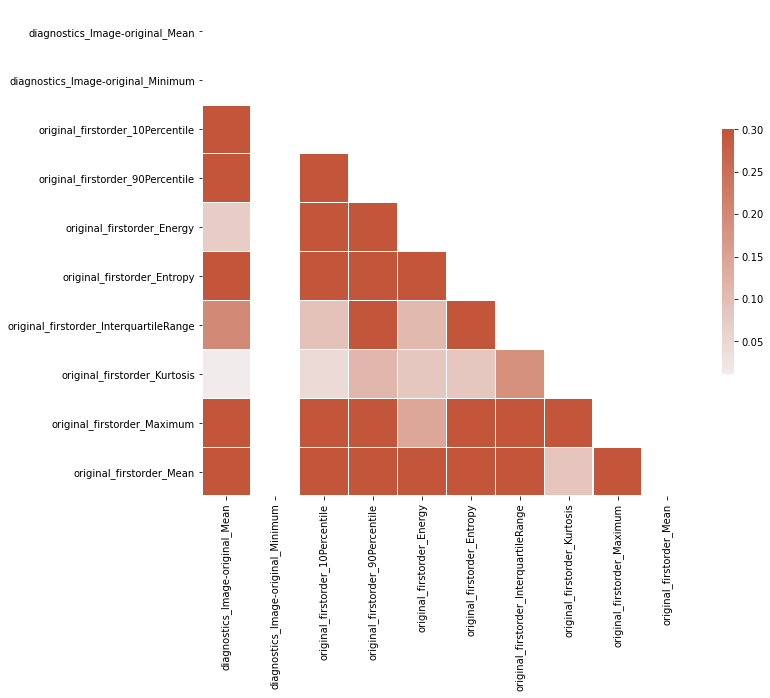

In [97]:
corr = aa
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Standardization and Scaling

In [7]:
# Mormalizing features using scikit-learn StandardScaler
scaler = StandardScaler()
scaledFeatures = scaler.fit_transform(df.values)

# Scaling features between 0 and 1. 
scaler2 = MinMaxScaler()
scaled2Features = scaler2.fit_transform(scaledFeatures)

### Feature Selection using univariate analysis

In [8]:
selector = SelectKBest(chi2, k=30)

labels = train_set.pop('ClinSig')
selectedFeatures = selector.fit_transform(scaled2Features,labels)

print(f"Number of features before feature selection: {scaledFeatures.shape[1]}")
print(f"Number of features after feature selection: {selectedFeatures.shape[1]}")

Number of features before feature selection: 66
Number of features after feature selection: 30


In [9]:
sc2f = pd.DataFrame(scaled2Features)
sef = pd.DataFrame(selectedFeatures)

column_nos = []
for i in range(0,len(sef.columns)):
    for j in range(0,len(sc2f.columns)):
        if np.all(sef[i] == sc2f[j]):
            column_nos.append(j)            

selectedfeatures_for_modelbuild = df.iloc[[i for i in range(len(df))], column_nos]
selectedfeatures_for_modelbuild

,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,original_firstorder_Minimum,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_Correlation,original_glcm_MCC,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_LargeDependenceEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_SurfaceVolumeRatio
0,962.0,236.256123,-0.375020,2.876723,0.441506,0.022046,0.149142,0.075833,15.238889,138.408333,102.350000,0.027224,0.019675,2.500000,1.750000,1.000000,0.252574,0.252601,0.016667,4358.500000,20.609401,0.022309,0.509156,4.614173,9.062395,7.500003,10.816656,170.625122,6.135634,1.152887
1,781.0,315.949401,-1.206585,1.000000,0.000000,1.000000,1.000000,0.071841,36.603946,406.000000,262.935961,0.008753,0.008753,1.000000,1.000000,1.000000,0.000006,0.000006,0.002463,0.000000,0.000000,1000000.000000,0.219393,3.829061,17.453012,10.295627,10.816651,289.937385,8.902252,1.242002
2,904.0,203.629306,-0.767837,1.189015,0.446668,0.383478,0.422439,0.103097,25.455993,194.426230,166.131148,0.029070,0.014764,5.285714,3.571429,1.857143,0.470444,1.881767,0.028689,5500.979592,9.140175,0.083423,0.471711,4.508246,9.557216,10.404330,7.810255,172.562692,5.920798,1.210747
3,904.0,203.629306,-0.834522,1.829943,0.490998,0.051030,0.140686,0.076856,18.324043,142.744361,91.150376,0.045857,0.023261,5.888889,3.333333,1.888889,0.390763,1.479706,0.033835,2633.580247,278.231658,0.019121,0.323673,4.081350,12.609491,10.547520,11.401762,188.781460,6.333008,1.272858
4,788.0,266.288479,-1.025125,1.132929,0.149692,0.045338,0.084877,0.075917,38.063033,466.078611,211.175503,0.034902,0.015590,19.095238,3.857143,6.428571,0.489265,1.957061,0.038391,11377.378685,23.397470,0.028167,0.464540,6.253636,13.461994,11.715376,13.453625,397.281313,8.164573,0.948405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,781.0,239.772547,-0.965799,1.013741,0.012988,-0.006919,0.006919,0.117928,35.807407,663.106667,293.945185,0.015767,0.009100,5.285714,3.571429,5.285714,0.857143,3.428572,0.010370,54639.673469,2.789070,0.184183,0.477725,6.690973,14.005895,13.972214,12.727926,623.478912,10.301022,0.807602
323,781.0,213.495126,-1.242311,1.345949,0.324840,0.062210,0.088327,0.065831,20.134876,264.807580,136.183673,0.022968,0.012989,3.400000,3.400000,1.000000,0.223192,0.892760,0.014577,13225.840000,28.128580,0.029313,0.369569,5.000116,13.529595,10.326127,13.131695,311.304199,7.451655,1.071520
324,781.0,213.495126,-0.650718,2.980841,0.577064,0.195241,0.212370,0.076743,18.470604,74.645161,105.080645,0.045164,0.034615,4.333333,1.500000,1.666667,0.416900,0.416962,0.048387,1055.222222,7.715659,0.055038,0.584630,4.126800,7.058826,8.618884,7.850408,109.278809,5.459877,1.298653
325,933.0,181.157649,-0.975331,1.563444,0.298966,-0.151271,0.469250,0.110050,10.171600,138.440000,77.740000,0.030704,0.018545,4.142857,3.142857,1.857143,0.116297,0.465058,0.035000,1174.530612,30.052276,0.038692,0.249551,4.377521,17.541600,10.326140,14.353261,173.825974,6.379137,1.362880


In [50]:
len(list(selectedfeatures_for_modelbuild.columns))

30

### Feature selection using PCA

In [11]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=8)
X_transformed = pca.fit_transform(scaled2Features)

In [38]:
fit = pca.fit(X_transformed)
print("Explained Variance: %s" % fit.explained_variance_ratio_)
print(fit.components_)

Explained Variance: [0.36443467 0.24651292 0.10280586 0.07873626 0.06866495 0.05939986
 0.04983307 0.02961241]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.00000000e+00 -1.11056567e-16 -4.03499418e-17
  -1.40356457e-16  1.51612094e-17  8.32752929e-17  9.16629710e-17]
 [ 0.00000000e+00 -5.59943873e-17  1.00000000e+00 -1.77388149e-17
  -4.04521183e-16  1.48794639e-16  6.93275216e-16 -3.46270117e-16]
 [-0.00000000e+00  1.18029808e-16  1.35863744e-16  1.00000000e+00
   6.16305566e-16  1.24360088e-15  1.98487010e-16 -9.21007914e-16]
 [-0.00000000e+00  1.40864822e-16  2.43589020e-16 -8.26833538e-16
   1.00000000e+00  3.62186482e-15 -1.59993334e-16 -2.28845593e-16]
 [ 0.00000000e+00 -5.37829554e-17  8.05196310e-17 -1.14790058e-15
  -3.67594468e-15  1.00000000e+00 -2.66731793e-15  9.60134007e-16]
 [-0.00000000e+00 -7.24921403e-17 -5.35009656e-16 -3.08265234e-17
   1.15792019e-16  2.5816

In [40]:
np.sum(fit.explained_variance_ratio_)

1.0

In [42]:
i = 1
for train_index, test_index in kf5.split(X_transformed):
    X_train = X_transformed[train_index]
    X_test = X_transformed[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    #Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, predictions)}")
    i += 1

(291, 8)
Accuracy for the fold no. 1 on the test set: 0.7878787878787878
(291, 8)
Accuracy for the fold no. 2 on the test set: 0.7575757575757576
(291, 8)
Accuracy for the fold no. 3 on the test set: 0.8787878787878788
(291, 8)
Accuracy for the fold no. 4 on the test set: 0.8484848484848485
(292, 8)
Accuracy for the fold no. 5 on the test set: 0.6875
(292, 8)
Accuracy for the fold no. 6 on the test set: 0.625
(292, 8)
Accuracy for the fold no. 7 on the test set: 0.90625
(292, 8)
Accuracy for the fold no. 8 on the test set: 0.96875
(292, 8)
Accuracy for the fold no. 9 on the test set: 0.78125
(292, 8)
Accuracy for the fold no. 10 on the test set: 0.4375


### Dataset split

In [14]:
# compare the number of repeats for repeated k-fold cross-validation
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [78]:
X,y = selectedFeatures, labels.reset_index(drop = True)
x_train, x_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

### MRMR selection

In [ ]:
import pymrmr
f = df[df.columns[0:40]]
pymrmr.mRMR(f, 'MIQ', 20)

### Logistic regression

#### K-fold CV with Logistic Regression 

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# roc_auc = roc_auc_score(y, clf.predict_proba(X)[:, 1])
def evaluate_model(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

repeats = range(1,11)
results = list()
for r in repeats:
    scores = evaluate_model(X, y, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    results.append(scores)


>1 mean=0.7713 se=0.037
>2 mean=0.7701 se=0.019
>3 mean=0.7716 se=0.015
>4 mean=0.7708 se=0.012
>5 mean=0.7710 se=0.010
>6 mean=0.7710 se=0.009
>7 mean=0.7707 se=0.008
>8 mean=0.7707 se=0.008
>9 mean=0.7706 se=0.008
>10 mean=0.7706 se=0.008


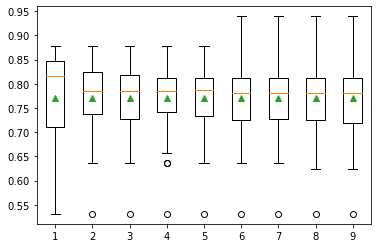

In [60]:
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()

In [79]:
lm = LogisticRegression()
model = lm.fit(x_test, y_test)
predictions = model.predict(x_test)

In [83]:
len(x_train), len(x_test)

(259, 65)

In [80]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[45,  0],
       [16,  4]])

In [85]:
print(list(y_test))
print(predictions)

[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
[1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
from sklearn.model_selection import KFold
kf5 = KFold(n_splits=10, shuffle=False)
kf3 = KFold(n_splits=3, shuffle=False)

In [74]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [106]:
i = 1
collect = []
for train_index, test_index in kf5.split(X):
    X_train = X[train_index]
    print(len(X_train))
    X_test = X[test_index]
    print(len(X_test))
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    #Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    collect.append(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print('rate',tp/(tp+fn))
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, predictions)}")
    i += 1

291
33
[[26  0]
 [ 7  0]]
rate 0.0
Accuracy for the fold no. 1 on the test set: 0.7878787878787878
291
33
[[25  0]
 [ 8  0]]
rate 0.0
Accuracy for the fold no. 2 on the test set: 0.7575757575757576
291
33
[[29  0]
 [ 3  1]]
rate 0.25
Accuracy for the fold no. 3 on the test set: 0.9090909090909091
291
33
[[28  0]
 [ 4  1]]
rate 0.2
Accuracy for the fold no. 4 on the test set: 0.8787878787878788
292
32
[[22  0]
 [10  0]]
rate 0.0
Accuracy for the fold no. 5 on the test set: 0.6875
292
32
[[20  0]
 [12  0]]
rate 0.0
Accuracy for the fold no. 6 on the test set: 0.625
292
32
[[29  0]
 [ 3  0]]
rate 0.0
Accuracy for the fold no. 7 on the test set: 0.90625
292
32
[[31  0]
 [ 1  0]]
rate 0.0
Accuracy for the fold no. 8 on the test set: 0.96875
292
32
[[25  0]
 [ 7  0]]
rate 0.0
Accuracy for the fold no. 9 on the test set: 0.78125
292
32
[[14  0]
 [18  0]]
rate 0.0
Accuracy for the fold no. 10 on the test set: 0.4375


In [62]:
collect

[0.7878787878787878,
 0.7575757575757576,
 0.9090909090909091,
 0.8787878787878788,
 0.6875,
 0.625,
 0.90625,
 0.96875,
 0.78125,
 0.4375]

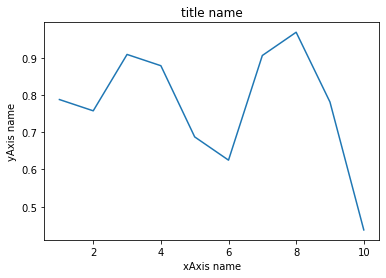

In [65]:
plt.plot(range(1,11),collect)
plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

Accuracy for the fold no. 1 on the test set: 0.7878787878787878
Logistic: ROC AUC=0.500


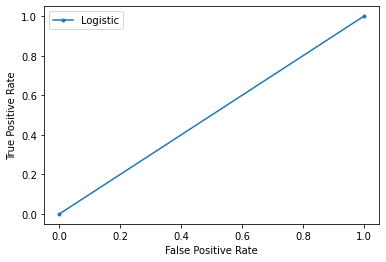

Accuracy for the fold no. 2 on the test set: 0.7575757575757576
Logistic: ROC AUC=0.500


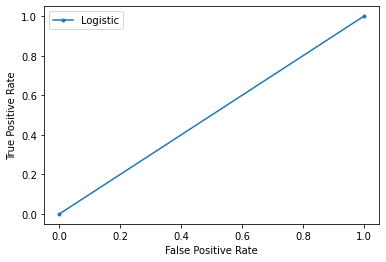

Accuracy for the fold no. 3 on the test set: 0.9090909090909091
Logistic: ROC AUC=0.625


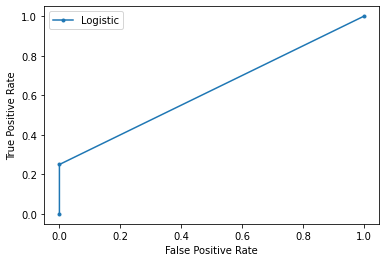

Accuracy for the fold no. 4 on the test set: 0.8787878787878788
Logistic: ROC AUC=0.600


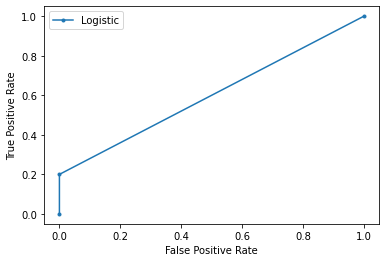

Accuracy for the fold no. 5 on the test set: 0.6875
Logistic: ROC AUC=0.500


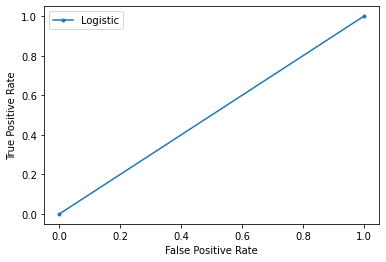

Accuracy for the fold no. 6 on the test set: 0.625
Logistic: ROC AUC=0.500


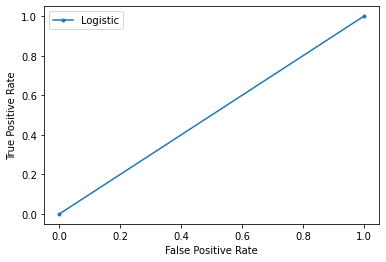

Accuracy for the fold no. 7 on the test set: 0.90625
Logistic: ROC AUC=0.500


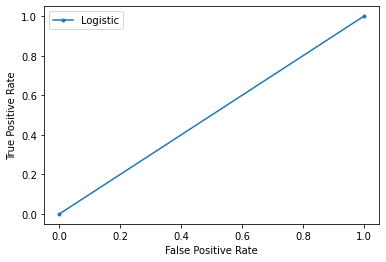

Accuracy for the fold no. 8 on the test set: 0.96875
Logistic: ROC AUC=0.500


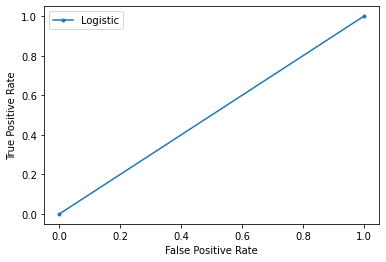

Accuracy for the fold no. 9 on the test set: 0.78125
Logistic: ROC AUC=0.500


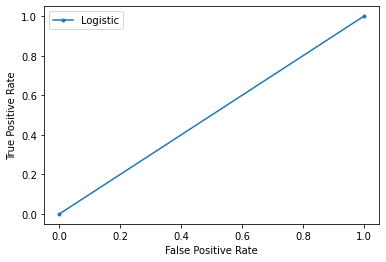

Accuracy for the fold no. 10 on the test set: 0.4375
Logistic: ROC AUC=0.500


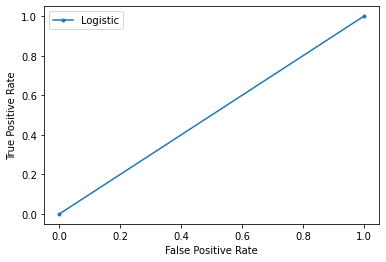

In [75]:
# Model with ROC AUC curve
i = 1
for train_index, test_index in kf5.split(X):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    #Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test, predictions)}")
    i += 1

    lr_auc = roc_auc_score(y_test, predictions)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions)
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.show()

### Naive Bayes

In [98]:
from sklearn.naive_bayes import GaussianNB

def evaluate_model(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = GaussianNB()
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

repeats = range(1,10)
results = list()
for r in repeats:
    scores = evaluate_model(X, y, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    results.append(scores)


>1 mean=0.6209 se=0.027
>2 mean=0.6177 se=0.019
>3 mean=0.6187 se=0.015
>4 mean=0.6170 se=0.013
>5 mean=0.6184 se=0.012
>6 mean=0.6228 se=0.011
>7 mean=0.6237 se=0.010
>8 mean=0.6224 se=0.010
>9 mean=0.6201 se=0.009


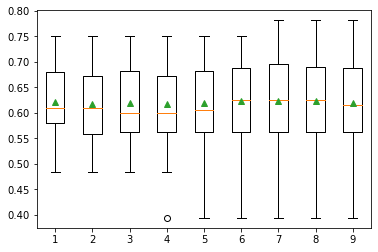

In [99]:
pyplot.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
pyplot.show()